In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from numba import jit
from tied_utils import simulated_tied_ddm_norm, tied_data_gen_wrapper, rho_E_minus_small_t_NORM_TIED_fn
from scipy.integrate import quad
from pyvbmc import VBMC
import corner
import random
from tqdm import tqdm

# params

In [2]:
# Stim params
ILD_arr = [-6, -3, 0, 3, 6]
# ABL_arr = [20, 40, 60]
ABL_arr = [60, 20, 40]

# Model params
rate_lambda = 0.076
theta_E = 50.7
T_0 = 0.19*(1e-3)
t_non_decision = 78*(1e-3)

# sim params
N_sim = int(1e5)
dt = 1e-4

# fitting params
K_max = 10

# gen data

In [3]:
sim_results = Parallel(n_jobs=-1)(delayed(tied_data_gen_wrapper)(ILD_arr, ABL_arr, rate_lambda, theta_E, T_0, t_non_decision, dt) for _ in range(N_sim))

# loglike fn

In [4]:
def compute_loglike(res, rate_lambda, theta_E, T_0, t_non_decision):
    ILD = res['ILD']
    ABL = res['ABL']
    choice = res['choice']
    rt = res['rt']

    if choice == 1:
        prob = rho_E_minus_small_t_NORM_TIED_fn(rt, ILD, ABL, rate_lambda, -theta_E, T_0, t_non_decision, K_max)
    elif choice == -1:
        prob = rho_E_minus_small_t_NORM_TIED_fn(rt, ILD, ABL, rate_lambda, theta_E, T_0, t_non_decision, K_max)

    log_prob = np.log(prob)
    if np.isnan(log_prob):
        print(f'nan loglike at params = {[rate_lambda, theta_E, T_0, t_non_decision]} for res = {res}')
        return np.log(1e-16)

    if np.isinf(log_prob):
        print(f'inf loglike at params = {[rate_lambda, theta_E, T_0, t_non_decision]} for res = {res}')
        return np.log(1e-16)

    return log_prob

def tied_loglike_fn(params):
    rate_lambda, theta_E, T_0, t_non_decision = params

    all_loglike = Parallel(n_jobs=-1)(delayed(compute_loglike)(res, rate_lambda, theta_E, T_0, t_non_decision) for res in sim_results)
    loglike = np.sum(all_loglike)

    return loglike

# Bounds

In [5]:
rate_lambda_bounds = [0.04, 0.15]
theta_E_bounds = [35, 65]
T_0_bounds = [0.1*(1e-3), 0.8*(1e-3)]
t_non_decision_bounds = [65*(1e-3), 85*(1e-3)]

rate_lambda_plausible_bounds = [0.05, 0.09]
theta_E_plausible_bounds = [40, 60]
T_0_plausible_bounds = [0.15*(1e-3), 0.3*(1e-3)]
t_non_decision_plausible_bounds = [70*(1e-3), 80*(1e-3)]

# True params
# rate_lambda = 0.076
# theta_E = 50.7
# T_0 = 0.19*(1e-3)
# t_non_decision = 78*(1e-3)

# Prior

In [6]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def tied_prior_fn(params):
    rate_lambda, theta_E, T_0, t_non_decision = params

    rate_lambda_logpdf = trapezoidal_logpdf(rate_lambda, rate_lambda_bounds[0], rate_lambda_plausible_bounds[0], \
                                            rate_lambda_plausible_bounds[1], rate_lambda_bounds[1])
    theta_E_logpdf = trapezoidal_logpdf(theta_E, theta_E_bounds[0], theta_E_plausible_bounds[0], \
                                            theta_E_plausible_bounds[1], theta_E_bounds[1])
    T_0_logpdf = trapezoidal_logpdf(T_0, T_0_bounds[0], T_0_plausible_bounds[0], \
                                            T_0_plausible_bounds[1], T_0_bounds[1])
    t_non_decision_logpdf = trapezoidal_logpdf(t_non_decision, t_non_decision_bounds[0], t_non_decision_plausible_bounds[0], \
                                            t_non_decision_plausible_bounds[1], t_non_decision_bounds[1])
    
    return rate_lambda_logpdf + theta_E_logpdf + T_0_logpdf + t_non_decision_logpdf

# prior + likelihood

In [7]:
def tied_joint_fn(params):
    return tied_loglike_fn(params) + tied_prior_fn(params)

# run vbmc

In [8]:
lb = np.array([rate_lambda_bounds[0], theta_E_bounds[0], T_0_bounds[0], t_non_decision_bounds[0]])
ub = np.array([rate_lambda_bounds[1], theta_E_bounds[1], T_0_bounds[1], t_non_decision_bounds[1]])
plb = np.array([rate_lambda_plausible_bounds[0], theta_E_plausible_bounds[0], T_0_plausible_bounds[0], t_non_decision_plausible_bounds[0]])
pub = np.array([rate_lambda_plausible_bounds[1], theta_E_plausible_bounds[1], T_0_plausible_bounds[1], t_non_decision_plausible_bounds[1]])

np.random.seed(42)
rate_lambda_0 = np.random.uniform(rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1])
theta_E_0 = np.random.uniform(theta_E_plausible_bounds[0], theta_E_plausible_bounds[1])
T_0_0 = np.random.uniform(T_0_plausible_bounds[0], T_0_plausible_bounds[1])
t_non_decision_0 = np.random.uniform(t_non_decision_plausible_bounds[0], t_non_decision_plausible_bounds[1])

x0 = np.array([rate_lambda_0, theta_E_0, T_0_0, t_non_decision_0])

vbmc = VBMC(tied_joint_fn, x0, lb, ub, plb, pub, options={'display': 'off'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 4).
Reshaping upper bounds to (1, 4).
Reshaping plausible lower bounds to (1, 4).
Reshaping plausible upper bounds to (1, 4).


/home/rka/.local/lib/python3.10/site-packages/pyvbmc/vbmc/active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 0. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)
/home/rka/.local/lib/python3.10/site-packages/pyvbmc/vbmc/active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 2. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)
/home/rka/.local/lib/python3.10/site-packages/pyvbmc/vbmc/active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 4. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)
/home/rka/.local/lib/python3.10/site-packages/pyvbmc/vbmc/active_sample.py:584: UserWarning: Rank-one update of Cholesky factor unstable for posterior 1. Reverting to full update.
  gp.update(xnew, ynew, compute_posterior=True)


Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: 67813.242 +/-0.001.


# corner

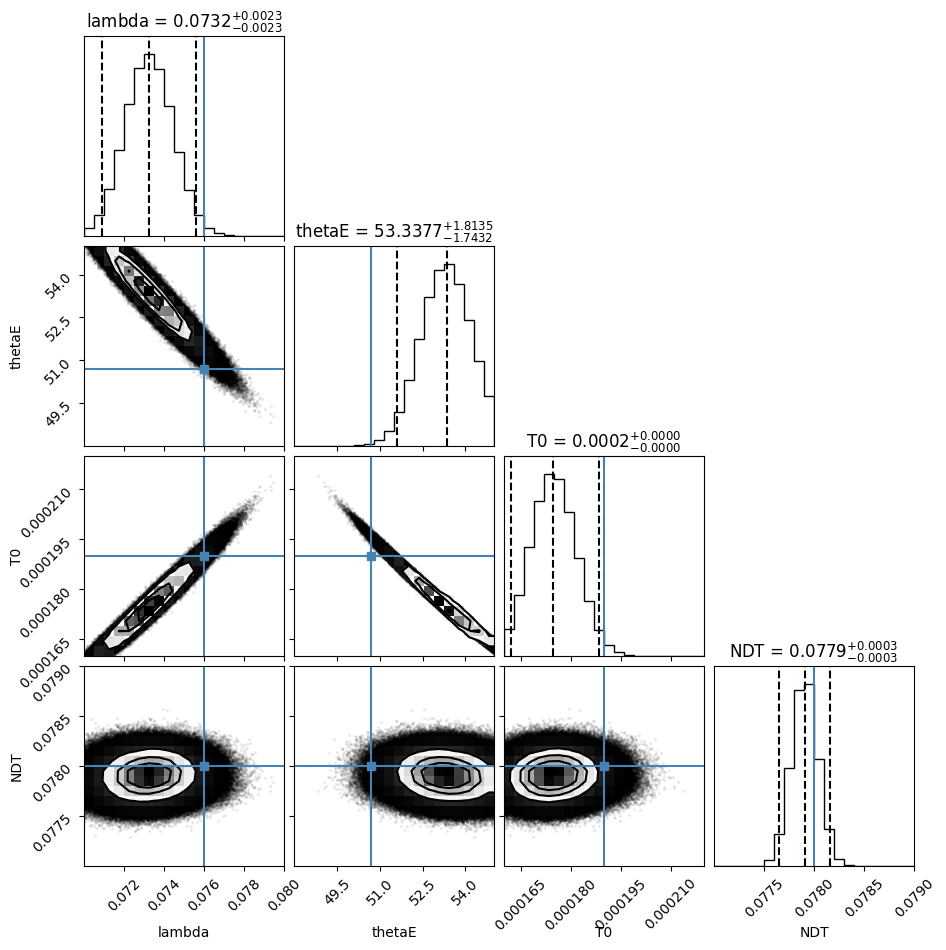

In [9]:
vp_samples = vp.sample(int(3e6))[0]

rate_lambda_samp = vp_samples[:, 0]
theta_E_samp = vp_samples[:, 1]
T_0_samp = vp_samples[:, 2]
t_non_decision_samp = vp_samples[:, 3]

combined_samples = np.transpose(np.vstack((rate_lambda_samp, theta_E_samp, T_0_samp, t_non_decision_samp)))
param_labels = ['lambda', 'thetaE', 'T0', 'NDT']
true_arr = [rate_lambda, theta_E, T_0, t_non_decision]
corner_span = [(0.07, 0.08), (48, 55), (0.16*(1e-3), 0.22*(1e-3)), (77*(1e-3), 79*(1e-3))]

corner.corner(combined_samples, labels=param_labels, show_titles=True, quantiles=[0.025, 0.5, 0.975], truths=true_arr, range=corner_span, title_fmt=".4f"  );


# tachometric curves

In [10]:
mean_rate_lambda = np.mean(rate_lambda_samp)
mean_theta_E = np.mean(theta_E_samp) 
mean_T_0 = np.mean(T_0_samp)
mean_t_non_decision = np.mean(t_non_decision_samp)

median_rate_lambda = np.median(rate_lambda_samp)
median_theta_E = np.median(theta_E_samp)
median_T_0 = np.median(T_0_samp)
median_t_non_decision = np.median(t_non_decision_samp)

/tmp/ipykernel_403966/358176428.py:9: RuntimeWarning: invalid value encountered in divide
  real_taco = real_up_prob/(real_up_prob + real_down_prob)
/tmp/ipykernel_403966/358176428.py:13: RuntimeWarning: invalid value encountered in divide
  mean_taco = mean_up_prob/(mean_up_prob + mean_down_prob)
/tmp/ipykernel_403966/358176428.py:17: RuntimeWarning: invalid value encountered in divide
  median_taco = median_up_prob/(median_up_prob + median_down_prob)


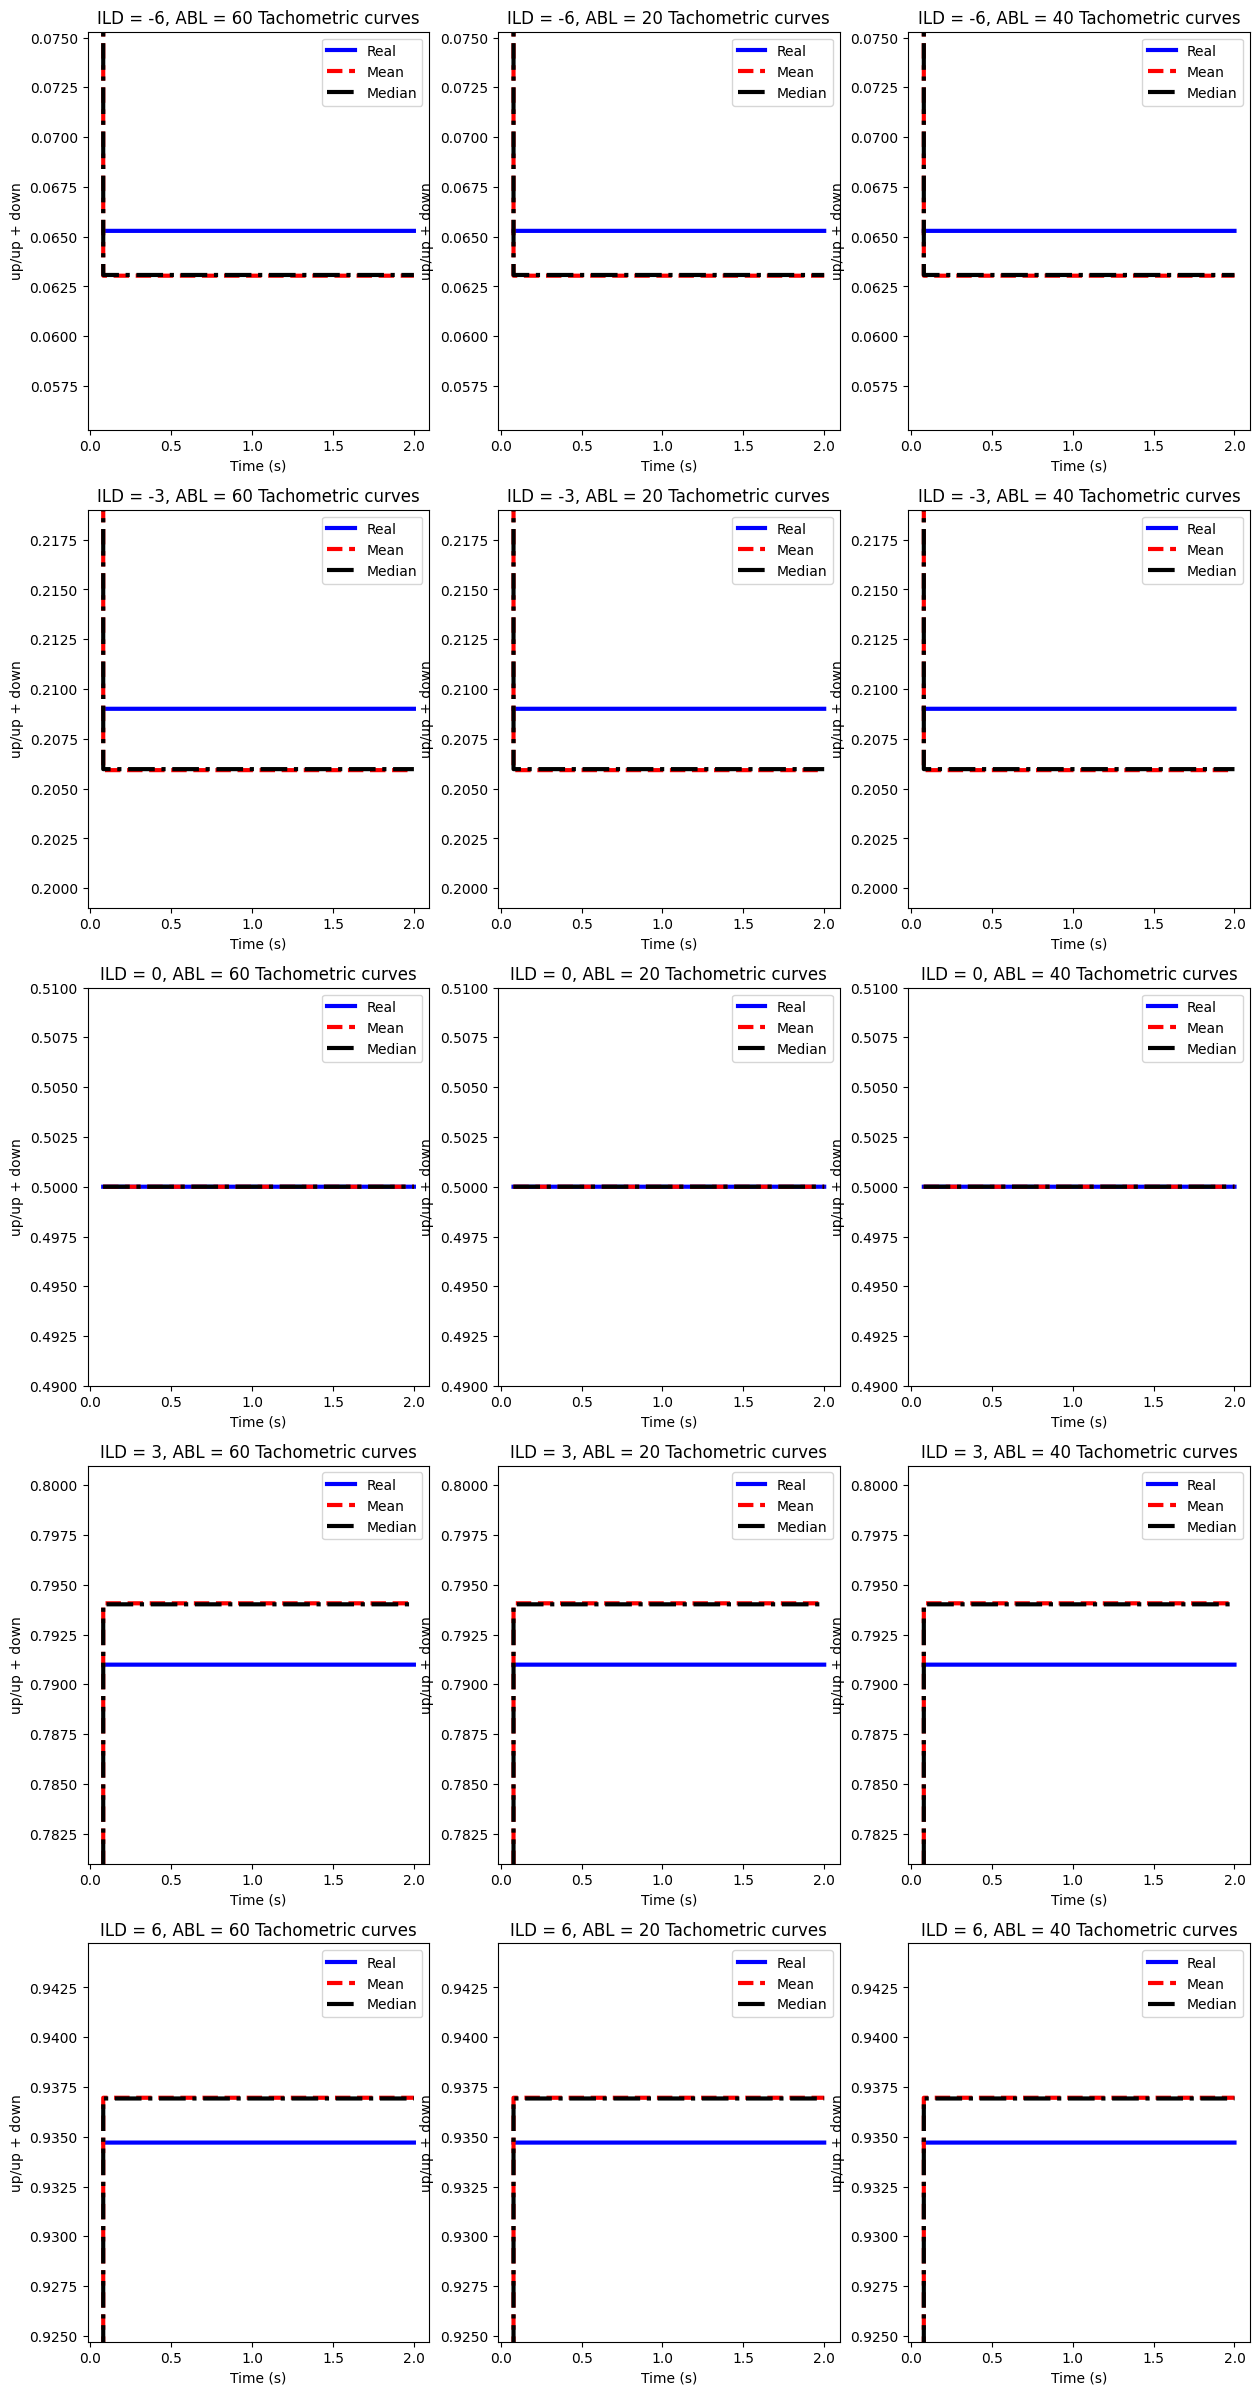

In [24]:
t_pts = np.linspace(0.001, 2, 2000)

plt.figure(figsize=(15, 30))
fig_num = 1
for ILD in ILD_arr:
    for ABL in ABL_arr:
        real_up_prob = np.array([rho_E_minus_small_t_NORM_TIED_fn(t, ILD, ABL, rate_lambda, -theta_E, T_0, t_non_decision, K_max) for t in t_pts])
        real_down_prob = np.array([rho_E_minus_small_t_NORM_TIED_fn(t, ILD, ABL, rate_lambda, theta_E, T_0, t_non_decision, K_max) for t in t_pts])
        real_taco = real_up_prob/(real_up_prob + real_down_prob)

        mean_up_prob = np.array([rho_E_minus_small_t_NORM_TIED_fn(t, ILD, ABL, mean_rate_lambda, -mean_theta_E, mean_T_0, mean_t_non_decision, K_max) for t in t_pts])
        mean_down_prob = np.array([rho_E_minus_small_t_NORM_TIED_fn(t, ILD, ABL, mean_rate_lambda, mean_theta_E, mean_T_0, mean_t_non_decision, K_max) for t in t_pts])
        mean_taco = mean_up_prob/(mean_up_prob + mean_down_prob)

        median_up_prob = np.array([rho_E_minus_small_t_NORM_TIED_fn(t, ILD, ABL, median_rate_lambda, -median_theta_E, median_T_0, median_t_non_decision, K_max) for t in t_pts])
        median_down_prob = np.array([rho_E_minus_small_t_NORM_TIED_fn(t, ILD, ABL, median_rate_lambda, median_theta_E, median_T_0, median_t_non_decision, K_max) for t in t_pts])
        median_taco = median_up_prob/(median_up_prob + median_down_prob)
        
        plt.subplot(len(ILD_arr),len(ABL_arr),fig_num)
        plt.plot(t_pts, real_taco, label='Real', linestyle='-', color='b', linewidth=3);
        plt.plot(t_pts, mean_taco, label='Mean', linestyle='--', color='r',  linewidth=3);
        plt.plot(t_pts, median_taco, label='Median', linestyle='-.', color='k',  linewidth=3);
        plt.legend();
        plt.xlabel('Time (s)');plt.ylabel('up/up + down');plt.title(f'ILD = {ILD}, ABL = {ABL} Tachometric curves');

        # plt.xlim([0.1, 2])
        plt.ylim([np.nanmean(real_taco) - 1e-2, np.nanmean(real_taco) + 1e-2])

        fig_num += 1


0.9347075663960478

# see likelihood of VBMC params

In [12]:
real_loglike = tied_loglike_fn([rate_lambda, theta_E, T_0, t_non_decision])
mean_loglike = tied_loglike_fn([mean_rate_lambda, mean_theta_E, mean_T_0, mean_t_non_decision])
median_loglike = tied_loglike_fn([median_rate_lambda, median_theta_E, median_T_0, median_t_non_decision])

print(f"Real  loglike = {real_loglike:.2f}, mean loglike = {mean_loglike:.2f}, median loglike = {median_loglike:.2f}")

Real  loglike = 67763.08, mean loglike = 67829.90, median loglike = 67830.00


# distribution of samples

In [13]:
vp_samples_2 = vp.sample(int(100))[0]

In [14]:
loglike_vp_samples = np.zeros((len(vp_samples_2)))
for i in tqdm(range(vp_samples_2.shape[0])):
    loglike_vp_samples[i] = tied_loglike_fn(vp_samples_2[i,:])

100%|██████████| 100/100 [03:01<00:00,  1.82s/it]


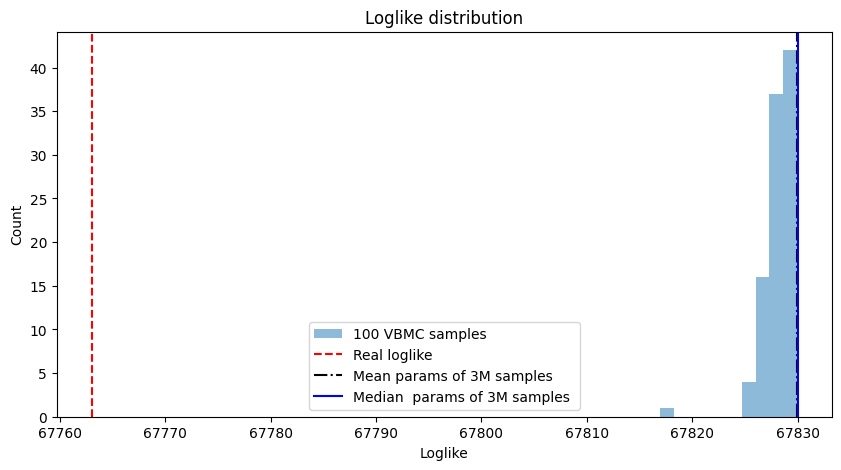

In [15]:
plt.figure(figsize=(10, 5))
plt.hist(loglike_vp_samples, alpha=0.5, label='100 VBMC samples');
plt.axvline(real_loglike, color='r', linestyle='--', label='Real loglike');
plt.axvline(mean_loglike, color='k', linestyle='-.', label='Mean params of 3M samples');
plt.axvline(median_loglike, color='b', linestyle='-', label='Median  params of 3M samples ');
plt.legend();
plt.xlabel('Loglike');plt.ylabel('Count');plt.title('Loglike distribution');